#### Module und Klassen importieren

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pylab as plt

from camcar import *

#### Main

In [9]:
# Objekte instanzieren
cam = Camera()
car = CamCar(cam)

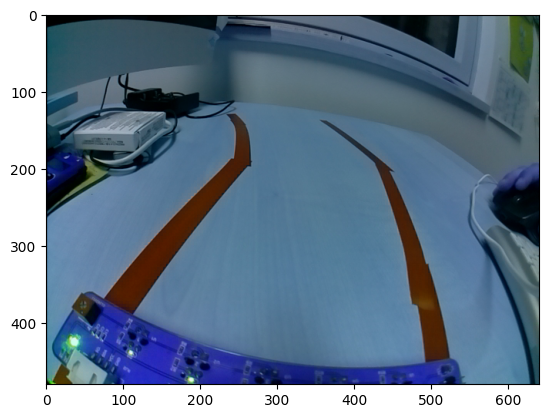

In [10]:
# Bild machen und Cam wieder freigeben
img = car.get_frame()
car.release()

# Bild speichern
cv.imwrite('test.jpg',img)

# Bild anzeigen
plt.imshow(img)